# 数据预处理模块

In [10]:
import json
import numpy as np
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import csv
import pandas as pd
import time
import datetime
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset,RandomSampler
import os
import urllib.request,urllib.parse
import zipfile
import win32api
import matplotlib.pyplot as plt
import difflib
import seaborn as sns
import random
root_path=os.path.abspath('.')
test_data_path='test_data.json'
test_data=json.loads(open(test_data_path,encoding='utf-8').read())
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}
userIds=[str(i) for i in sorted([int(i) for i in list(test_data.keys())])]
updateUserIds={}
getOldUserId=[]
for i in range(len(userIds)):
    updateUserIds.update({userIds[i]:i})
    getOldUserId.append(userIds[i])
del userIds
case_ids=set()
for i in test_data:
    for j in test_data[i]['cases']:
        case_ids.add(j['case_id'])
case_ids=sorted(list(case_ids))
updateCaseIds={}
getOldCaseId=[]
for i in range(len(case_ids)):
    updateCaseIds.update({case_ids[i]:i})
    getOldCaseId.append(case_ids)
del case_ids
new_data=[]
for i in range(271):
    new_data.append(test_data[getOldUserId[i]]['cases'])
del test_data
for i in range(271):
    for j in range(len(new_data[i])):
        new_data[i][j]['case_id']=updateCaseIds[new_data[i][j]['case_id']]
userFinishCaseIds=[]
for i in range(271):
    tempList=[]
    for j in range(len(new_data[i])):
        tempList.append(new_data[i][j]['case_id'])
    userFinishCaseIds.append(sorted(tempList))
caseIds200=[]
groupCaseIds=[]
ids882=[i for i in range(882)]
theFifthGroupCaseIds=set()
for i in range(271):
    ids='.'.join([str(i) for i in userFinishCaseIds[i]])
    if len(userFinishCaseIds[i])==200 and ids not in caseIds200:
        caseIds200.append(ids)
        groupCaseIds.append(userFinishCaseIds[i])
        for j in userFinishCaseIds[i]:
            ids882[j]=-1
for i in ids882:
    if i!=-1:
        theFifthGroupCaseIds.add(i)
fifthGroupIds=list(theFifthGroupCaseIds)
for i in range(271):
    if 190<=len(userFinishCaseIds[i])<=200:
        flag=False
        for j in theFifthGroupCaseIds:
            if j in userFinishCaseIds[i]:
                flag=True
                break
        if flag:
            for j in userFinishCaseIds[i]:
                fifthGroupIds.append(j)
groupCaseIds.append(sorted(list(set(fifthGroupIds))))
del fifthGroupIds
del theFifthGroupCaseIds
del ids882
del caseIds200
groupUserIds=[[] for i in range(5)]
ctGroupUserIds=[]
validUserIds=[]
for i in range(271):
    if len(userFinishCaseIds[i])>200:
        groupUserIds[4].append(i)
        continue
    if len(userFinishCaseIds[i])<=10:
        ctGroupUserIds.append(i)
        continue
    if i==261:
        groupUserIds[3].append(i)
        continue
    g=[]
    for j in range(5):
        flag=True
        for k in userFinishCaseIds[i]:
            if not k in groupCaseIds[j]:
                flag=False
                break
        if flag:
            g.append(j)
    if len(g)==1:
        groupUserIds[g[0]].append(i)
    else:
        ctGroupUserIds.append(i)
for i in groupUserIds:
    for j in i:
        validUserIds.append(j)
validUserIds=sorted(validUserIds)
groupUserNum=[len(i) for i in groupUserIds]
caseGroups=[[] for i in range(882)]
caseUserNum=[0 for i in range(882)]
caseUserNumInFact=[0 for i in range(882)]
caseScoreIgnoreUndo=[0 for i in range(882)]
caseScoreCountUndo=[0 for i in range(882)]
caseIdsByType=[set() for i in range(8)]
for i in range(882):
    for j in userFinishCaseIds:
        if i in j:
            caseUserNumInFact[i]+=1
    for j in range(len(groupCaseIds)):
        if i in groupCaseIds[j]:
            caseGroups[i].append(j)
            caseUserNum[i]+=groupUserNum[j]
caseFinishRate=list(np.array(caseUserNumInFact)/np.array(caseUserNum))
for i in range(len(new_data)):
    if i not in validUserIds:
        continue
    for j in range(len(new_data[i])):
        caseScoreIgnoreUndo[new_data[i][j]['case_id']]+=new_data[i][j]['final_score']
caseScoreCountUndo=list(np.array(caseScoreIgnoreUndo)/np.array(caseUserNum))
caseScoreIgnoreUndo=list(np.array(caseScoreIgnoreUndo)/np.array(caseUserNumInFact))
for i in range(len(new_data)):
    for j in range(len(new_data[i])):
        new_data[i][j]['case_type']=type_dict[new_data[i][j]['case_type']]
        caseIdsByType[new_data[i][j]['case_type']].add(new_data[i][j]['case_id'])
for i in range(len(caseIdsByType)):
    caseIdsByType[i]=sorted(list(caseIdsByType[i]))
def getGroupIdByUserId(userId):
    for i in range(len(groupUserIds)):
        if userId in groupUserIds[i]:
            return i
    return -1
def getGroupIdsByCaseId(caseId):
    gs=[]
    for i in range(len(groupCaseIds)):
        if caseId in groupCaseIds[i]:
            gs.append(i)
    return gs
def getTypesByCaseId(caseId):
    ts=[]
    for i in range(len(caseIdsByType)):
        if caseId in caseIdsByType[i]:
            ts.append(i)
    return ts
def getScoreByUserIdAndCaseId(userId,caseId):
    """
    返回某个用户在某道题上的得分,如果用户应该做这道题而没有做,则返回0分,如果这道题这个用户本来就不需要做(即用户所在的group内不包含这道题),就返回-1
    :param userId:
    :param caseId:
    :return:
    """
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -1
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['final_score']
    return 0
def getCaseIdsByGroupAndType(groupId,typeId):
    return sorted(list(set(caseIdsByType[typeId])&set(groupCaseIds[groupId])))
def getUploadNumByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -1
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return len(i['upload_records'])
    return 0
def getFinalUploadCodeUrlByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return ''
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['upload_records'][-1]['code_url']
    return ''
def getUploadSumByCaseId(caseId):
    r=0
    for i in validUserIds:
        r+=(getUploadNumByUserAndCase(i,caseId) if getUploadNumByUserAndCase(i,caseId)>0 else 0)
    return r
def getTimeSpanByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -2
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['upload_records'][-1]['upload_time']-i['upload_records'][0]['upload_time']
    return -1
def getAvgTimeSpanByCase(caseId):
    r=0
    n=0
    for i in validUserIds:
        if getTimeSpanByUserAndCase(i,caseId)>-1:
            r+=getTimeSpanByUserAndCase(i,caseId)
            n+=1
    return r/n
typeOneHot=OneHotEncoder(categories='auto').fit([[i] for i in range(8)]).transform([[i] for i in range(8)]).toarray()
groupOneHot=OneHotEncoder(categories='auto').fit([[i] for i in range(5)]).transform([[i] for i in range(5)]).toarray()
cases_analysis_result=np.array([])
def time_diff_minute(firstTime,secondTime):
    return (datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(secondTime/1000)),"%Y-%m-%d %H:%M:%S")-datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(firstTime/1000)),"%Y-%m-%d %H:%M:%S")).total_seconds()/60
def getTimeSpanByUserAndCaseInMinute(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -2
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return time_diff_minute(i['upload_records'][0]['upload_time'],i['upload_records'][-1]['upload_time'])
    return -1
def getAvgTimeSpanByCaseInMinute(caseId):
    r=0
    n=0
    for i in validUserIds:
        if getTimeSpanByUserAndCaseInMinute(i,caseId)>-1:
            r+=getTimeSpanByUserAndCaseInMinute(i,caseId)
            n+=1
    return r/n
for i in range(882):
    typeId=np.zeros((8,))
    for j in getTypesByCaseId(i):
        typeId+=np.array(typeOneHot[j])
    finishRate=caseFinishRate[i]
    userNum=caseUserNum[i]
    userNumInFact=caseUserNumInFact[i]
    scoreIgnoreUndo=caseScoreIgnoreUndo[i]
    scoreCountUndo=caseScoreCountUndo[i]
    groupId=np.zeros((5,))
    for j in getGroupIdsByCaseId(i):
        groupId+=np.array(groupOneHot[j])
    uploadSum=getUploadSumByCaseId(i)
    uploadAvg=uploadSum/userNum
    uploadAvgInFact=uploadSum/userNumInFact
    timeSpan=getAvgTimeSpanByCaseInMinute(i)
    caseLine=np.concatenate((np.array([i]),typeId,np.array([finishRate]),np.array([userNum]),np.array([userNumInFact]),np.array([scoreIgnoreUndo]),np.array([scoreCountUndo]),groupId,np.array([uploadSum]),np.array([uploadAvg]),np.array([uploadAvgInFact]),np.array([timeSpan])),axis=0).reshape(1,-1)
    if i==0:
        cases_analysis_result=caseLine
    else:
        cases_analysis_result=np.concatenate((cases_analysis_result,caseLine),axis=0)
with open('cases_analysis_result.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','type0','type1','type2','type3','type4','type5','type6','type7','finishRate','userNum','userNumInFact','scoreIgnoreUndo','scoreCountUndo','group0','group1','group2','group3','group4','uploadSum','uploadAvg','uploadAvgInFact','timeSpan']
    cw.writerow(header)
    for i in cases_analysis_result:
        cw.writerow(list(i))
"""
cases_analysis_result 数据说明:
shape:(882,23)
各列含义:
id:case_id 0~881
type0:如果这道题的类型是0类型,则此列为1,否则为0
type1~type7同上
finishRate:这道题的完成率 做了这道题的人数/应该做这道题的总人数
userNum:应该做这道题的总人数
userNumInFact:实际上做了这道题的人数
scoreIgnoreUndo:这道题的平均得分,忽略没做的人
scoreCountUndo:这道题的平均得分,如果应该做而没有做这道题的人,此题得分记为0
group0:如果这道题是第0组中的题目,则为1,否则为0
group1~group4同上
uploadSum:这道题的提交总次数
uploadAvg:平均每个人在这道题上的提交次数,如果有人应该做而没有做这道题,则提交次数记为0
uploadAvgInFact:平均每个人在这道题上的提交次数,忽略没有做这道题的人
timeSpan:做这道题的平均时间跨度,即最后一次提交时间减去第一次提交时间,单位是分钟
"""
cases_analysis_result=pd.read_csv('cases_analysis_result.csv')
cases_analysis_result['timeSpan']=StandardScaler().fit_transform(np.array(cases_analysis_result['timeSpan']).reshape(-1,1))
cases_analysis_result['uploadSum']=StandardScaler().fit_transform(np.array(cases_analysis_result['uploadSum']).reshape(-1,1))
cases_analysis_result['scoreIgnoreUndo']=StandardScaler().fit_transform(np.array(cases_analysis_result['scoreIgnoreUndo']).reshape(-1,1))
cases_analysis_result['scoreCountUndo']=StandardScaler().fit_transform(np.array(cases_analysis_result['scoreCountUndo']).reshape(-1,1))
cases_analysis_result['userNum']=StandardScaler().fit_transform(np.array(cases_analysis_result['userNum']).reshape(-1,1))
cases_analysis_result['userNumInFact']=StandardScaler().fit_transform(np.array(cases_analysis_result['userNumInFact']).reshape(-1,1))
caseAllScores=[[] for i in range(882)]
for i in validUserIds:
    for j in range(len(new_data[i])):
        caseAllScores[new_data[i][j]['case_id']].append(new_data[i][j]['final_score'])
casesScoreVar=[np.var(np.array(caseAllScores[i])) for i in range(882)]
cases_analysis_result['scoreVar']=StandardScaler().fit_transform(np.array(casesScoreVar).reshape(-1,1))
def getCodeRunTime(code_url,userId,caseId):
    try:
        os.chdir('allcases')

        dirname=str(userId)+'_'+str(caseId)+'_dir'#存放原压缩包解压物的，每道题都有专属的文件夹名
        name=str(userId)+'_'+str(caseId)+'_zip'#原压缩包名

        urllib.request.urlretrieve(code_url,name)#下载原压缩包
        url_file=zipfile.ZipFile(name)#为原压缩包解压做准备

        os.mkdir(dirname)#原压缩包解压目录
        os.chdir(dirname)
        url_file.extractall()#原压缩包解压

        tmp=os.listdir(os.curdir)#当前目录为原压缩包解压目录，即获取原压缩包解压出来的压缩包名
        temp=tmp[0]#第二个压缩包名
        tempp=zipfile.ZipFile(temp)
        tempp.extractall()
        #第二个压缩包在此解压

        tmp=os.listdir(os.curdir)#再次获取当前目录内的所有文件名，以获得py文件进行运行
        code_name=''
        for i in tmp:
            if i[-3::]=='.py':
                code_name=i#py文件名

        start_time=time.clock()
        win32api.ShellExecute(0,'open',code_name,'','',0)
        end_time=time.clock()

        os.chdir('..')#返回至allcases目录
        os.chdir('..')#返回主目录

        return end_time-start_time
    except:
        os.chdir('..')#返回至allcases目录
        os.chdir('..')#返回主目录
        return -1
def getUserIdsByCaseId(caseId):
    r=[]
    for i in validUserIds:
        if caseId in userFinishCaseIds[i]:
            r.append(i)
    return r
# def getCodeRunTime(code_url,userId,caseId):
#     return random.uniform(0,1)
codeRunTime=-np.ones((271,882))
# 下载所有代码并计算运行时间
# for i in validUserIds:
#     for j in range(882):
#         if getFinalUploadCodeUrlByUserAndCase(i,j)!='':
#             codeRunTime[i,j]=getCodeRunTime(getFinalUploadCodeUrlByUserAndCase(i,j),i,j)
#             os.chdir(root_path)
# 抽样下载代码并计算运行时间
# for j in range(882):
#     for i in [random.choice(getUserIdsByCaseId(j))]:
#         if getFinalUploadCodeUrlByUserAndCase(i,j)!='':
#             codeRunTime[i,j]=getCodeRunTime(getFinalUploadCodeUrlByUserAndCase(i,j),i,j)
#             os.chdir(root_path)
# with open('code_run_time.csv',mode='w',newline='') as file:
#     cw=csv.writer(file)
#     for i in codeRunTime:
#         cw.writerow(list(i))
codeRunTime=pd.read_csv('code_run_time.csv',header=None).values
def getCaseAvgRunTime(caseId):
    sumTime=0
    for i in validUserIds:
        if codeRunTime[i,caseId]>-1:
            sumTime+=codeRunTime[i,caseId]
    return sumTime/caseUserNumInFact[caseId]
cases_analysis_result['avgRunTime']=StandardScaler().fit_transform(np.array([getCaseAvgRunTime(i) for i in range(882)]).reshape(-1,1))
def difficult_degree(caseId):
    """
    题目的难度系数,值越大说明题目越难,各列的系数可能还需要调整
    :param caseId:
    :return:
    """
    return -cases_analysis_result.iloc[caseId]['finishRate']-cases_analysis_result.iloc[caseId]['scoreIgnoreUndo']-cases_analysis_result.iloc[caseId]['scoreCountUndo']+cases_analysis_result.iloc[caseId]['uploadAvg']+cases_analysis_result.iloc[caseId]['uploadAvgInFact']+cases_analysis_result.iloc[caseId]['timeSpan']+cases_analysis_result.iloc[caseId]['avgRunTime']
cases_analysis_result['difficultDegree']=np.array([difficult_degree(i) for i in range(882)]).reshape(-1,1)
cases_analysis_result.to_csv('cases_analysis_final.csv')
cases_result_array=cases_analysis_result.values
def getTypeDifficultDegree(typeId):
    d=0
    for caseId in caseIdsByType[typeId]:
        d+=difficult_degree(caseId)
    return d/len(caseIdsByType[typeId])
def getGroupDifficultDegree(groupId):
    d=0
    for caseId in groupCaseIds[groupId]:
        d+=difficult_degree(caseId)
    return d/len(groupCaseIds[groupId])
def getDifficultDegreeByGroupAndType(groupId,typeId):
    d=0
    n=0
    for caseId in groupCaseIds[groupId]:
        if caseId in caseIdsByType[typeId]:
            n+=1
            d+=difficult_degree(caseId)
    return d/n
def getTypeAvgScoreIgnoreUndo(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['scoreIgnoreUndo']
    return s/len(caseIdsByType[typeId])
def getGroupAvgScoreIgnoreUndo(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['scoreIgnoreUndo']
    return s/len(groupCaseIds[groupId])
def getTypeAvgScoreCountUndo(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['scoreCountUndo']
    return s/len(caseIdsByType[typeId])
def getGroupAvgScoreCountUndo(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['scoreCountUndo']
    return s/len(groupCaseIds[groupId])
def test_cases_oriented(path):
    f=open(path,'r',encoding='utf-8')
    #以下为测行数、print数
    count=1  #行数
    pcount=0 #print数
    ifcount=0 # if elif else数
    line=f.readline()
    line=line[:-1]
    while line:
        if line.count("print")>0:
            pcount+=1
        if line.count("if")>0 or line.count("elif") or line.count("else")>0:
            ifcount+=1
        line=line.strip()  #去掉前后空格
        if line: #不为空行
            if not line[0]=="#": #不为注释行
                count+=1
        line=f.readline()
    #以下为检测
    return pcount>5 or (pcount/count)>0.3 or count<5 or ifcount>5 or ifcount/count>0.3
def getGroupAvgFinishRate(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=caseFinishRate[caseId]
    return s/len(groupCaseIds[groupId])
def getTypeAvgFinishRate(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=caseFinishRate[caseId]
    return s/len(caseIdsByType[typeId])
def getGroupAvgUploadNum(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['uploadAvg']
    return s/len(groupCaseIds[groupId])
def getTypeAvgUploadNum(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['uploadAvg']
    return s/len(caseIdsByType[typeId])
def getGroupAvgUploadNumInFact(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['uploadAvgInFact']
    return s/len(groupCaseIds[groupId])
def getTypeAvgUploadNumInFact(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['uploadAvgInFact']
    return s/len(caseIdsByType[typeId])
def getGroupAvgTimeSpanInMinute(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=getAvgTimeSpanByCaseInMinute(caseId)
    return s/len(groupCaseIds[groupId])
def getTypeAvgTimeSpanInMinute(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=getAvgTimeSpanByCaseInMinute(caseId)
    return s/len(caseIdsByType[typeId])
def getGoodnessOfCase(caseId):
    return 30+cases_analysis_result.iloc[caseId]['finishRate']-abs(cases_analysis_result.iloc[caseId]['scoreIgnoreUndo']-cases_analysis_result['scoreIgnoreUndo'].mean())+cases_analysis_result.iloc[caseId]['scoreVar']-abs(cases_analysis_result.iloc[caseId]['difficultDegree']-cases_analysis_result['difficultDegree'].mean())-abs(cases_analysis_result.iloc[caseId]['uploadAvgInFact']-3)
def getGoodnessOfType(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=getGoodnessOfCase(caseId)
    return s/len(caseIdsByType[typeId])
def getGoodnessOfGroup(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=getGoodnessOfCase(caseId)
    return s/len(groupCaseIds[groupId])
def copy_detector(path1,path2,threshold=0.6):
    with open(path1,encoding='utf-8') as file1:
        code1=''
        ls=file1.readlines()
        for line in ls:
            temp=line.lstrip()
            if temp and not temp.startswith('#'):
                code1+=temp
    with open(path2,encoding='utf-8') as file2:
        code2=''
        ls=file2.readlines()
        for line in ls:
            temp=line.lstrip()
            if temp and not temp.startswith('#'):
                code2+=temp
    return difflib.SequenceMatcher(None,code1,code2).ratio()>=threshold

# PCA 降维到4维

In [44]:
# new_dim=2
new_dim=4
# cases_data_pca=PCA(n_components=new_dim).fit_transform(cases_result_array)
model_pca=PCA(n_components=new_dim).fit(cases_result_array)
cases_data_pca=model_pca.transform(cases_result_array)
cases_reconstructed=model_pca.inverse_transform(cases_data_pca)
with open('cases_pca_4_dim_result.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1','dim2','dim3']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_data_pca[i,0],cases_data_pca[i,1],cases_data_pca[i,2],cases_data_pca[i,3]])
pca_loss=np.mean(np.square(cases_result_array-cases_reconstructed))
print('PCA 4 dim mean square loss:{}'.format(pca_loss))

PCA 4 dim mean square loss:0.13871950667820518


# PCA 降维到2维

In [45]:
new_dim=2
# new_dim=4
# cases_data_pca=PCA(n_components=new_dim).fit_transform(cases_result_array)
model_pca=PCA(n_components=new_dim).fit(cases_result_array)
cases_data_pca=model_pca.transform(cases_result_array)
cases_reconstructed=model_pca.inverse_transform(cases_data_pca)
with open('cases_pca_2_dim_result.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_data_pca[i,0],cases_data_pca[i,1]])
pca_loss=np.mean(np.square(cases_result_array-cases_reconstructed))
print('PCA 2 dim mean square loss:{}'.format(pca_loss))

PCA 2 dim mean square loss:0.2976193041640051


# 把数据转成Tensor格式

In [46]:
batch_size=32
cases_tensor=torch.tensor(cases_result_array,dtype=torch.float)
cases_dataset=TensorDataset(cases_tensor)
cases_sampler=RandomSampler(cases_dataset)
cases_dataloader=DataLoader(cases_dataset,sampler=cases_sampler,batch_size=batch_size)


# AE & VAE 降维到2维
## AE & VAE 模型定义

In [47]:
dim=cases_result_array.shape[1]
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(dim,20),
            nn.ReLU(True),
            nn.Linear(20,16),
            nn.ReLU(True),
            nn.Linear(16,8),
            nn.ReLU(True),
            nn.Linear(8,4),
            nn.ReLU(True),
            nn.Linear(4,2)
        )
        self.decoder=nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(True),
            nn.Linear(4,8),
            nn.ReLU(True),
            nn.Linear(8,16),
            nn.ReLU(True),
            nn.Linear(16,20),
            nn.ReLU(True),
            nn.Linear(20,dim)
        )
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1=nn.Linear(dim,16)
        self.fc21=nn.Linear(16,2)
        self.fc22=nn.Linear(16,2)
        self.fc3=nn.Linear(2,16)
        self.fc4=nn.Linear(16,dim)
    def encoder(self,x):
        h1=F.relu(self.fc1(x))
        return self.fc21(h1),self.fc22(h1)
    def reparametrize(self,mu,logvar):
        std=logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps=torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps=torch.FloatTensor(std.size()).normal_()
        eps=Variable(eps)
        return eps.mul(std).add_(mu)
    def decode(self,z):
        h3=F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    def forward(self,x):
        mu,logvar=self.encoder(x)
        z=self.reparametrize(mu,logvar)
        return self.decode(z),mu,logvar
def loss_vae(recon_x,x,mu,logvar,criterion):
    """
    recon_x: generating values
    x: origin values
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD
model_classes={'AE':AE(),'VAE':VAE()}
learning_rate=1e-3
num_epochs=2000
# num_epochs=0 # 已经训练好了

## Train AE

In [48]:
model_type='AE'
# model_type='VAE'
model=model_classes[model_type].cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    for data in cases_dataloader:
        batch_cases=data[0].cuda()
        output=model(batch_cases)
        if model_type=='VAE':
            loss=loss_vae(output[0],batch_cases,output[1],output[2],criterion)
        else:
            loss=criterion(output,batch_cases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item()<best_loss:
            best_loss=loss.item()
            torch.save(model,'best_model_{}_2_dim.pt'.format(model_type))
    # if (epoch+1)%50==0:
    # print('epoch [{}/{}],loss:{:.4f}'.format(epoch+1,num_epochs,loss.item()))
    if (epoch+1)%100==0 or epoch==0:
        print('epoch ['+str(epoch+1)+'/'+str(num_epochs)+'],loss:'+str(loss.item()))
print('Best '+model_type+' model\' loss:'+str(best_loss))
final_model=torch.load('best_model_AE_2_dim.pt')
cases_ae_encoder=final_model.encoder(cases_tensor.cuda()).detach().cpu().numpy()
with open('cases_ae_encode_2_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_ae_encoder[i,0],cases_ae_encoder[i,1]])


C:\Users\60960\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch [1/2000],loss:5375.42919921875
epoch [100/2000],loss:1.5279216766357422
epoch [200/2000],loss:0.8029865026473999
epoch [300/2000],loss:0.7911138534545898
epoch [400/2000],loss:0.6096683144569397
epoch [500/2000],loss:0.7754116654396057
epoch [600/2000],loss:0.817295491695404
epoch [700/2000],loss:1.1490877866744995
epoch [800/2000],loss:0.6539499759674072
epoch [900/2000],loss:1.1336991786956787
epoch [1000/2000],loss:0.6970823407173157
epoch [1100/2000],loss:0.6419059634208679
epoch [1200/2000],loss:0.5764960050582886
epoch [1300/2000],loss:0.3725663721561432
epoch [1400/2000],loss:0.384949266910553
epoch [1500/2000],loss:0.3952477276325226
epoch [1600/2000],loss:0.5831933617591858
epoch [1700/2000],loss:0.18598684668540955
epoch [1800/2000],loss:0.37410634756088257
epoch [1900/2000],loss:0.18918655812740326
epoch [2000/2000],loss:0.36269959807395935
Best AE model' loss:0.13609889149665833


## Train VAE


In [49]:
# model_type='AE'
model_type='VAE'
model=model_classes[model_type].cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    for data in cases_dataloader:
        batch_cases=data[0].cuda()
        output=model(batch_cases)
        if model_type=='VAE':
            loss=loss_vae(output[0],batch_cases,output[1],output[2],criterion)
        else:
            loss=criterion(output,batch_cases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item()<best_loss:
            best_loss=loss.item()
            torch.save(model,'best_model_{}_2_dim.pt'.format(model_type))
    # if (epoch+1)%50==0:
    # print('epoch [{}/{}],loss:{:.4f}'.format(epoch+1,num_epochs,loss.item()))
    if (epoch+1)%100==0 or epoch==0:
        print('epoch ['+str(epoch+1)+'/'+str(num_epochs)+'],loss:'+str(loss.item()))
print('Best '+model_type+' model\' loss:'+str(best_loss))
final_model=torch.load('best_model_VAE_2_dim.pt')
cases_vae_encoder=final_model.encoder(cases_tensor.cuda())[0].detach().cpu().numpy()
with open('cases_vae_encode_2_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_vae_encoder[i,0],cases_vae_encoder[i,1]])


C:\Users\60960\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\60960\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch [1/2000],loss:10342.6064453125
epoch [100/2000],loss:10556.076171875
epoch [200/2000],loss:11199.6845703125
epoch [300/2000],loss:12288.248046875
epoch [400/2000],loss:8786.1923828125
epoch [500/2000],loss:10055.162109375
epoch [600/2000],loss:10264.267578125
epoch [700/2000],loss:7826.16064453125
epoch [800/2000],loss:14685.962890625
epoch [900/2000],loss:10959.8271484375
epoch [1000/2000],loss:12995.03515625
epoch [1100/2000],loss:10529.208984375
epoch [1200/2000],loss:10101.2119140625
epoch [1300/2000],loss:7112.88623046875
epoch [1400/2000],loss:9829.373046875
epoch [1500/2000],loss:9509.7490234375
epoch [1600/2000],loss:11904.224609375
epoch [1700/2000],loss:10005.5556640625
epoch [1800/2000],loss:8809.65625
epoch [1900/2000],loss:12563.28515625
epoch [2000/2000],loss:9548.66796875
Best VAE model' loss:4468.6591796875


# AE & VAE 降维到4维
## AE & VAE 模型定义

In [50]:
dim=cases_result_array.shape[1]
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(dim,20),
            nn.ReLU(True),
            nn.Linear(20,16),
            nn.ReLU(True),
            nn.Linear(16,8),
            nn.ReLU(True),
            nn.Linear(8,4)
        )
        self.decoder=nn.Sequential(
            nn.Linear(4,8),
            nn.ReLU(True),
            nn.Linear(8,16),
            nn.ReLU(True),
            nn.Linear(16,20),
            nn.ReLU(True),
            nn.Linear(20,dim)
        )
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1=nn.Linear(dim,16)
        self.fc21=nn.Linear(16,4)
        self.fc22=nn.Linear(16,4)
        self.fc3=nn.Linear(4,16)
        self.fc4=nn.Linear(16,dim)
    def encoder(self,x):
        h1=F.relu(self.fc1(x))
        return self.fc21(h1),self.fc22(h1)
    def reparametrize(self,mu,logvar):
        std=logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps=torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps=torch.FloatTensor(std.size()).normal_()
        eps=Variable(eps)
        return eps.mul(std).add_(mu)
    def decode(self,z):
        h3=F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    def forward(self,x):
        mu,logvar=self.encoder(x)
        z=self.reparametrize(mu,logvar)
        return self.decode(z),mu,logvar
def loss_vae(recon_x,x,mu,logvar,criterion):
    """
    recon_x: generating values
    x: origin values
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD
model_classes={'AE':AE(),'VAE':VAE()}
learning_rate=1e-3
num_epochs=2000
# num_epochs=0 # 已经训练好了


## Train AE

In [51]:
model_type='AE'
# model_type='VAE'
model=model_classes[model_type].cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    for data in cases_dataloader:
        batch_cases=data[0].cuda()
        output=model(batch_cases)
        if model_type=='VAE':
            loss=loss_vae(output[0],batch_cases,output[1],output[2],criterion)
        else:
            loss=criterion(output,batch_cases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item()<best_loss:
            best_loss=loss.item()
            torch.save(model,'best_model_{}_4_dim.pt'.format(model_type))
    # if (epoch+1)%50==0:
    # print('epoch [{}/{}],loss:{:.4f}'.format(epoch+1,num_epochs,loss.item()))
    if (epoch+1)%100==0 or epoch==0:
        print('epoch ['+str(epoch+1)+'/'+str(num_epochs)+'],loss:'+str(loss.item()))
print('Best '+model_type+' model\' loss:'+str(best_loss))
final_model=torch.load('best_model_AE_4_dim.pt')
cases_ae_encoder=final_model.encoder(cases_tensor.cuda()).detach().cpu().numpy()
with open('cases_ae_encode_4_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1','dim2','dim3']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_ae_encoder[i,0],cases_ae_encoder[i,1],cases_ae_encoder[i,2],cases_ae_encoder[i,3]])



epoch [1/2000],loss:7487.82958984375
epoch [100/2000],loss:0.3725070357322693
epoch [200/2000],loss:0.9923311471939087
epoch [300/2000],loss:0.35196101665496826
epoch [400/2000],loss:0.29708805680274963
epoch [500/2000],loss:0.4278900623321533
epoch [600/2000],loss:0.27035120129585266
epoch [700/2000],loss:1.2398667335510254
epoch [800/2000],loss:0.36756402254104614
epoch [900/2000],loss:0.394062876701355
epoch [1000/2000],loss:0.7929007411003113
epoch [1100/2000],loss:0.29412582516670227
epoch [1200/2000],loss:0.2850358784198761
epoch [1300/2000],loss:0.2269110232591629
epoch [1400/2000],loss:0.2951788306236267
epoch [1500/2000],loss:0.44792744517326355
epoch [1600/2000],loss:0.41643226146698
epoch [1700/2000],loss:0.2579497992992401
epoch [1800/2000],loss:0.3996681869029999
epoch [1900/2000],loss:0.22203929722309113
epoch [2000/2000],loss:0.36679112911224365
Best AE model' loss:0.12725231051445007


## Train VAE

In [52]:

# model_type='AE'
model_type='VAE'
model=model_classes[model_type].cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    for data in cases_dataloader:
        batch_cases=data[0].cuda()
        output=model(batch_cases)
        if model_type=='VAE':
            loss=loss_vae(output[0],batch_cases,output[1],output[2],criterion)
        else:
            loss=criterion(output,batch_cases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item()<best_loss:
            best_loss=loss.item()
            torch.save(model,'best_model_{}_4_dim.pt'.format(model_type))
    # if (epoch+1)%50==0:
    # print('epoch [{}/{}],loss:{:.4f}'.format(epoch+1,num_epochs,loss.item()))
    if (epoch+1)%100==0 or epoch==0:
        print('epoch ['+str(epoch+1)+'/'+str(num_epochs)+'],loss:'+str(loss.item()))
print('Best '+model_type+' model\' loss:'+str(best_loss))
final_model=torch.load('best_model_VAE_4_dim.pt')
cases_vae_encoder=final_model.encoder(cases_tensor.cuda())[0].detach().cpu().numpy()
with open('cases_vae_encode_4_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1','dim2','dim3']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_vae_encoder[i,0],cases_vae_encoder[i,1],cases_vae_encoder[i,2],cases_vae_encoder[i,3]])


epoch [1/2000],loss:3.929740457017344e+17
epoch [100/2000],loss:4294169329664.0
epoch [200/2000],loss:8291140239360.0
epoch [300/2000],loss:985208512.0
epoch [400/2000],loss:7973082624.0
epoch [500/2000],loss:2068561408.0
epoch [600/2000],loss:140760400.0
epoch [700/2000],loss:165399008.0
epoch [800/2000],loss:14278.1826171875
epoch [900/2000],loss:8752.7763671875
epoch [1000/2000],loss:5993.62255859375
epoch [1100/2000],loss:9238.2451171875
epoch [1200/2000],loss:10521.5263671875
epoch [1300/2000],loss:7309.04638671875
epoch [1400/2000],loss:13592.1494140625
epoch [1500/2000],loss:12815.015625
epoch [1600/2000],loss:10724.505859375
epoch [1700/2000],loss:11835.3056640625
epoch [1800/2000],loss:12683.2685546875
epoch [1900/2000],loss:8651.755859375
epoch [2000/2000],loss:7287.6142578125
Best VAE model' loss:3780.02880859375


# 降维处理已结束,下面是基于学生答题表现的聚类分析

In [132]:
cases_analysis_result=pd.read_csv('cases_analysis_result.csv')
cases_analysis_final=pd.read_csv('cases_analysis_final.csv').iloc[:,1:]

cases_pca_2_dim=pd.read_csv('cases_pca_2_dim_result.csv')
cases_pca_4_dim=pd.read_csv('cases_pca_4_dim_result.csv')
cases_ae_2_dim=pd.read_csv('cases_ae_encode_2_dim.csv')
cases_ae_4_dim=pd.read_csv('cases_ae_encode_4_dim.csv')
cases_vae_2_dim=pd.read_csv('cases_vae_encode_2_dim.csv')
cases_vae_4_dim=pd.read_csv('cases_vae_encode_4_dim.csv')

cases_analysis_final['difficultDegree']=StandardScaler().fit_transform(np.array(cases_analysis_final['difficultDegree']).reshape(-1,1))

cases_pca_2_dim['dim0']=StandardScaler().fit_transform(np.array(cases_pca_2_dim['dim0']).reshape(-1,1))
cases_pca_2_dim['dim1']=StandardScaler().fit_transform(np.array(cases_pca_2_dim['dim1']).reshape(-1,1))

cases_ae_2_dim['dim0']=StandardScaler().fit_transform(np.array(cases_ae_2_dim['dim0']).reshape(-1,1))
cases_ae_2_dim['dim1']=StandardScaler().fit_transform(np.array(cases_ae_2_dim['dim1']).reshape(-1,1))

cases_ae_4_dim['dim0']=StandardScaler().fit_transform(np.array(cases_ae_4_dim['dim0']).reshape(-1,1))
cases_ae_4_dim['dim1']=StandardScaler().fit_transform(np.array(cases_ae_4_dim['dim1']).reshape(-1,1))
cases_ae_4_dim['dim2']=StandardScaler().fit_transform(np.array(cases_ae_4_dim['dim2']).reshape(-1,1))
cases_ae_4_dim['dim3']=StandardScaler().fit_transform(np.array(cases_ae_4_dim['dim3']).reshape(-1,1))

cases_vae_2_dim['dim0']=StandardScaler().fit_transform(np.array(cases_vae_2_dim['dim0']).reshape(-1,1))
cases_vae_2_dim['dim1']=StandardScaler().fit_transform(np.array(cases_vae_2_dim['dim1']).reshape(-1,1))

cases_vae_4_dim['dim0']=StandardScaler().fit_transform(np.array(cases_vae_4_dim['dim0']).reshape(-1,1))
cases_vae_4_dim['dim1']=StandardScaler().fit_transform(np.array(cases_vae_4_dim['dim1']).reshape(-1,1))
cases_vae_4_dim['dim2']=StandardScaler().fit_transform(np.array(cases_vae_4_dim['dim2']).reshape(-1,1))
cases_vae_4_dim['dim3']=StandardScaler().fit_transform(np.array(cases_vae_4_dim['dim3']).reshape(-1,1))

km_pca_2_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_pca_2_dim.iloc[:,1:].values)
km_pca_4_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_pca_4_dim.iloc[:,1:].values)
km_ae_2_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_ae_2_dim.iloc[:,1:].values)
km_ae_4_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_ae_4_dim.iloc[:,1:].values)
km_vae_2_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_vae_2_dim.iloc[:,1:].values)
km_vae_4_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_vae_4_dim.iloc[:,1:].values)
km_raw=KMeans(n_clusters=8,max_iter=2000).fit(cases_analysis_final)

mark=['or','ob','og','ok','^r','+r','sr','dr','<r','pr']

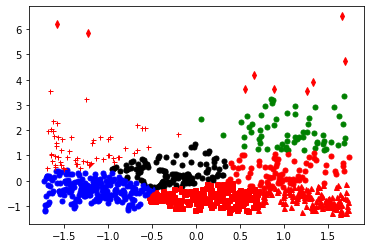

In [118]:
data=cases_pca_2_dim.iloc[:,1:].values
j=0
for i in km_pca_2_dim.labels_:
    plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
    j+=1
plt.show()

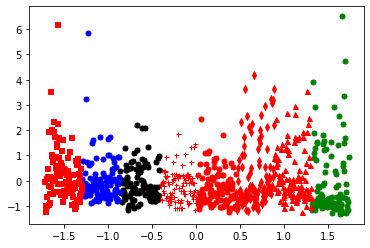

In [136]:
data=cases_pca_2_dim.iloc[:,1:].values
j=0
for i in km_raw.labels_:
    plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
    j+=1
plt.show()

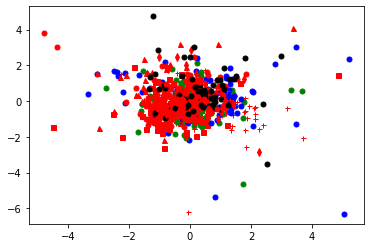

In [121]:
data=cases_vae_2_dim.iloc[:,1:].values
j=0
for i in km_vae_4_dim.labels_:
    plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
    j+=1
plt.show()

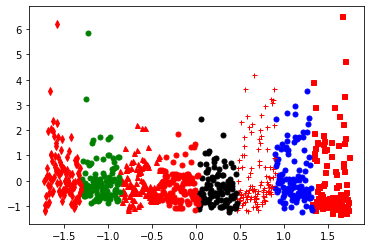

In [137]:
data=cases_pca_2_dim.iloc[:,1:].values
j=0
for i in km_pca_4_dim.labels_:
    plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
    j+=1
plt.show()

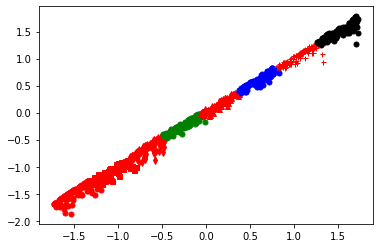

In [140]:
data=cases_ae_2_dim.iloc[:,1:].values
j=0
for i in km_ae_2_dim.labels_:
    plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
    j+=1
plt.show()


# 题目视角部分的数据可视化


True